# Direct Fidelity Estimation

Using a method known as direct fidelity estimation (DFE), see [DFE1] and [DFE2], it is possible to estimate the fidelity between 
* a target pure state $\rho_\psi = |\psi\rangle\langle \psi|$ to its experimental realization $\sigma$,
* a target unitary $U$ to its experimental realization $U_e$.
 
This can be done with a small number (relative to state and process tomography) of simple experimental settings that is independent of the system size. Such methods are useful for the experimental study of larger quantum information processing units.

In this notebook we explore some state and process DFE using the forest.benchmarking module `direct_fidelity_estimation.py`.

## Simplistic example

Suppose we have tried to prepare the state $|0\rangle$ but in fact prepared the state

$$\sigma = \frac 1 2 (I + x X + y Y + z Z).$$


The usual way to quantify how close $\sigma$ and $|0\rangle$ are is to do quantum state tomography 
and estimate $\sigma$ and then calculate the fidelity be $\sigma$ and $|0\rangle$.


DFE provides a way to directly estimate the fidelity without first estimating the state $\sigma$. Although we can write the fidelity as $F(\rho_0, \sigma) = \langle 0 |\sigma|0 \rangle$ we use the expression

$$
F(\rho_0, \sigma) = {\rm Tr}[\rho_0  \sigma].
$$
Next we parameterize the pure state as

$$\rho_0= |0\rangle \langle 0| =  \frac 1 2 \big (I + (0) X + (0) Y + (+1) Z \big)=  \frac 1 2 (I +  Z ).$$

Finally we arrive at

$$
F(\rho_0, \sigma)= {\rm Tr}[\rho_0 \sigma] = \frac 1 4 {\rm Tr}[(1+z)I]= \frac{(1+z)}{2},
$$
this result shows that we only need to estimate one observable $\langle Z \rangle$ in order to estimate the fidelity.


## Addtional Details

**State DFE:** State fidelity between the experimental state $\sigma$ and the ideal (pure) state $\rho_\psi = |\psi\rangle\langle \psi|$ 
matrices is 

$$
F(\rho_\psi, \sigma) = {\rm Tr}[\rho_\psi  \sigma] = \langle \psi |\sigma|\psi \rangle.
$$

The direct fidelity estimate for a state is given by the average expected value of the Pauli operators in the
stabilizer group of the ideal pure state (see Eqn. 1 of [DFE1]).

**Process DFE:** The average gate fidelity between the experimental process $\mathcal E$ and the ideal (unitary) process $\mathcal U$ is defined as
$$
F(\mathcal U,\mathcal E) = \frac{ {\rm Tr} [\mathcal E \mathcal U^\dagger] + d} {d^2+d} 
$$
where the processes are represented by linear superoperators acting of vectorized
density matrices, and d is the dimension of the Hilbert space $\mathcal E$ and $\mathcal U$ act on. If you are unfamiliar with these terms look at [superoperator tools notebook](superoperator_tools.ipynb).

The average gate fidelity can be re-written a 
$$
F(\mathcal U,\mathcal E)= \frac{d^2 {\rm Tr} J(\mathcal E)⋅J(\mathcal U) + d}{d^2+d}
$$
where $J()$ is the Choi-Jamiolkoski representation of the superoperator in the argument. Since the Choi-Jamiolkowski representation
is given by a density operator, the connection to the calculation of state fidelity becomes apparent:
$F(J(ℰ),J(𝒰)) = {\rm Tr} J(\mathcal E)⋅J(\mathcal U)$ is the state fidelity between Choi-Jamiolkoski states.

Noting that the Choi-Jamiolkoski state is prepared by acting on half of a maximally entangled state with the
process in question, the direct fidelity estimate of the Choi-Jamiolkoski state is given by the average expected
value of a Pauli operator resulting from applying the ideal unitary $\mathcal U$ to a Pauli operator $P_i$, for the state
resulting from applying the ideal unitary to a stabilizer state that has $P_i$ in its stabilizer group (one must be
careful to prepare states that have both +1 and -1 eigenstates of the operator in question, to emulate the random
state preparation corresponding to measuring half of a maximally entangled state).

[DFE1]  Practical Characterization of Quantum Devices without Tomography  
        Silva et al.,  
        PRL 107, 210404 (2011)  
        https://doi.org/10.1103/PhysRevLett.107.210404  
        https://arxiv.org/abs/1104.3835  

[DFE2]  Direct Fidelity Estimation from Few Pauli Measurements  
        Flammia et al.,  
        PRL 106, 230501 (2011)  
        https://doi.org/10.1103/PhysRevLett.106.230501  
        https://arxiv.org/abs/1104.4695  

In [3]:
from pyquil.paulis import ID
from pyquil.gates import I, X, MEASURE, H, CZ, RY
from pyquil import Program, get_qc
from pyquil.api import get_benchmarker
from forest.benchmarking.direct_fidelity_estimation import ( generate_exhaustive_state_dfe_experiment, 
                                                             generate_exhaustive_process_dfe_experiment,
                                                             generate_monte_carlo_state_dfe_experiment, 
                                                             generate_monte_carlo_process_dfe_experiment,
                                                             acquire_dfe_data,
                                                             estimate_dfe )

import numpy as np
from matplotlib import pyplot

In [4]:
# noiseless QVM
qvm = get_qc("9q-generic-qvm", as_qvm=True, noisy=False)

# noisy QVM
noisy_qvm = get_qc("9q-generic-qvm", as_qvm=True, noisy=True)

bm = get_benchmarker()

## State DFE

### State prep (thing we will do DFE on)

In [30]:
p = Program()
prep_prog = p.inst(H(0), CZ(0,1))
print(prep_prog)

H 0
CZ 0 1



### Get things required for a DFE experiment ... aka experiment object

Namely return a namedtuple consisiting of 
- pauli_in, 
- prog, 
- pauli_out.

In [31]:
# state dfe
state_exp = generate_exhaustive_state_dfe_experiment(prep_prog,[0,1],bm)

# process dfe
process_exp = generate_exhaustive_process_dfe_experiment(prep_prog,[0,1],bm)

### Acquire DFE data (noiseless)

Returns dfe data 'data' and calibration data 'cal' namedtuple separately

In [32]:
results = acquire_dfe_data(qvm, process_exp, num_shots=1000)
print("================================")
print([res.expectation for res in results])
print("================================")
print([res.calibration_expectation for res in results])

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


### Acquire DFE data (noisy QVM)

In [33]:
n_results = acquire_dfe_data(noisy_qvm, process_exp, num_shots=1000)
print("================================")
print([res.expectation for res in n_results])
print("================================")
print([res.calibration_expectation for res in n_results])

[1.0057251908396947, 0.9516539440203562, 0.9703095388502843, 1.005685407454201, 1.0213963963963963, 0.9774774774774775, 0.9755011135857461, 1.0023068050749713, 0.9850057670126874, 0.986409966024915, 0.9920724801812004, 0.9872935196950444, 0.9695044472681067, 0.9443207126948775, 1.011534025374856, 1.0023068050749713, 0.986409966024915, 0.971687429218573, 0.9777636594663277, 0.9536213468869122, 0.9767587939698491, 0.9547738693467336, 0.961683417085427, 1.0091205211726384, 1.0104234527687297, 0.9784824462061155, 0.9988674971687429, 0.9767587939698491, 0.9453517587939697, 0.9585427135678392, 0.9732899022801303, 0.993485342019544, 0.9682899207248018, 0.9898074745186863, 0.9890885750962772, 0.9811688311688311, 0.9766233766233766, 0.9755312298776562, 0.9594333547971668, 0.9886877828054299, 0.995475113122172, 1.006418485237484, 0.9811688311688311, 0.9753246753246753, 0.9748873148744366, 0.9819703799098519, 0.9864253393665158, 0.9705882352941176]
[0.786, 0.786, 0.7915, 0.7915, 0.888, 0.888, 0.8

### Estimate fidelity (noiseless QVM)

In [34]:
fid_est, fid_std_err = estimate_dfe(results,'process')
print("==================================================")
print('Fidelity point estimate is',fid_est)
print('The standard error of the fidelity point estimate is', fid_std_err)
print("==================================================")

Fidelity point estimate is 1.0
The standard error of the fidelity point estimate is 0.0


### Estimate fidelity (noisy QVM)

In [35]:
nfid_est, nfid_std_err = estimate_dfe(n_results,'process')
print("==================================================")
print('Fidelity point estimate is', nfid_est)
print('The std error of the fidelity point estimate is', nfid_std_err)
print("==================================================")

Fidelity point estimate is 0.9861939597950375
The std error of the fidelity point estimate is 0.0019095604013575757


## State fidelity between $\left|0\right\rangle$ and $R_y(\theta)\left|0\right\rangle$

In [15]:
#%%time
p = Program(I(0),I(1))
zz_state = generate_exhaustive_state_dfe_experiment(p, [0,1], bm)
zz_state_mc = generate_monte_carlo_state_dfe_experiment(p, [0,1], bm, n_terms=32)
print(zz_state)
print(zz_state_mc)

I 0; I 1
0: Z0_1→(1+0j)*Z1
1: Z0_0→(1+0j)*Z0
2: Z0_0 * Z0_1→(1+0j)*Z0Z1
I 0; I 1
0: Z0_0 * Z0_1→(1+0j)*Z0Z1
1: Z0_1→(1+0j)*Z1
2: Z0_1→(1+0j)*Z1
3: Z0_0 * Z0_1→(1+0j)*Z0Z1
4: Z0_0→(1+0j)*Z0
5: Z0_0 * Z0_1→(1+0j)*Z0Z1
6: Z0_0→(1+0j)*Z0
7: Z0_1→(1+0j)*Z1
8: Z0_1→(1+0j)*Z1
9: Z0_1→(1+0j)*Z1
... 12 not shown ...
... use e.settings_string() for all ...
22: Z0_0 * Z0_1→(1+0j)*Z0Z1
23: Z0_0→(1+0j)*Z0
24: Z0_1→(1+0j)*Z1
25: Z0_1→(1+0j)*Z1
26: Z0_0 * Z0_1→(1+0j)*Z0Z1
27: Z0_1→(1+0j)*Z1
28: Z0_0 * Z0_1→(1+0j)*Z0Z1
29: Z0_0→(1+0j)*Z0
30: Z0_1→(1+0j)*Z1
31: Z0_1→(1+0j)*Z1


### Exhaustive

In [16]:
points = 10
res = []
res_std_err = []
for theta in np.linspace(0, np.pi, points): 
    zz_state.program = Program(RY(theta,0),RY(theta,1))
    zz_state_data = acquire_dfe_data(qvm,zz_state,num_shots=1000)
    fid_est, fid_std_err = estimate_dfe(zz_state_data, 'state')
    res.append(fid_est)
    res_std_err.append(fid_std_err)

Text(0.5, 1.0, 'State fidelity between $\\left|0\\right\\rangle$ and $R_y(\\theta)\\left|0\\right\\rangle$')

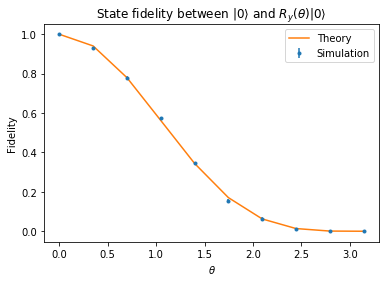

In [17]:
pyplot.errorbar(np.linspace(0, np.pi, points), res, res_std_err, fmt=".", label="Simulation")
pyplot.plot(np.linspace(0, np.pi, points), (1/2+1/2*np.cos(np.linspace(0, np.pi, points)))**2, label="Theory")
pyplot.xlabel(r"$\theta$")
pyplot.ylabel("Fidelity")
pyplot.legend()
pyplot.title(r"State fidelity between $\left|0\right\rangle$ and $R_y(\theta)\left|0\right\rangle$")

### Monte-Carlo

In [18]:
points = 10
res = []
res_std_err = []
for theta in np.linspace(0, np.pi, points): 
    zz_state_mc.program = Program(RY(theta,0),RY(theta,1))
    zz_state_mc_data = acquire_dfe_data(qvm, zz_state_mc, num_shots=1000)
    fid_est, fid_std_err = estimate_dfe(zz_state_mc_data, 'state')
    res.append(fid_est)
    res_std_err.append(fid_std_err)

Text(0.5, 1.0, 'State fidelity between $\\left|0\\right\\rangle$ and $R_y(\\theta)\\left|0\\right\\rangle$')

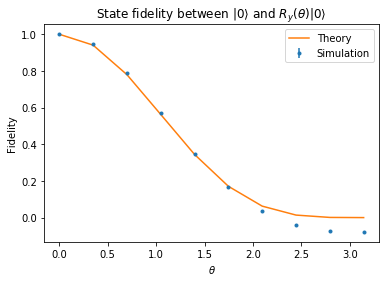

In [19]:
pyplot.errorbar(np.linspace(0, np.pi, points), res, res_std_err, fmt=".", label="Simulation")
pyplot.plot(np.linspace(0, np.pi, points), (1/2+1/2*np.cos(np.linspace(0, np.pi, points)))**2, label="Theory")
pyplot.xlabel(r"$\theta$")
pyplot.ylabel("Fidelity")
pyplot.legend()
pyplot.title(r"State fidelity between $\left|0\right\rangle$ and $R_y(\theta)\left|0\right\rangle$")

## State fidelity between $\left|0\right\rangle\left|0\right\rangle$ and $R_y(\theta)\otimes R_y(2\theta)\left|0\right\rangle\left|0\right\rangle$

### Exhaustive

In [20]:
points = 10
res = []
res_std_err = []
for theta in np.linspace(0, np.pi, points): 
    zz_state.program = Program(RY(theta,0),RY(2*theta,1))
    zz_state_data = acquire_dfe_data(qvm,zz_state,num_shots=1_000)
    fid_est, fid_std_err = estimate_dfe(zz_state_data, 'state')
    res.append(fid_est)
    res_std_err.append(fid_std_err)

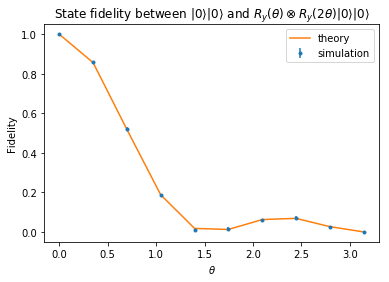

In [21]:
pyplot.errorbar(np.linspace(0, np.pi, points), res, res_std_err, fmt=".", label="simulation")
pyplot.plot(np.linspace(0, np.pi, points), 
            (1/2+1/2*np.cos(np.linspace(0, np.pi, points)))*(1/2+1/2*np.cos(2*np.linspace(0, np.pi, points))),
            label="theory")
pyplot.xlabel(r"$\theta$")
pyplot.ylabel("Fidelity")
pyplot.legend()
pyplot.title(r"State fidelity between $\left|0\right\rangle\left|0\right\rangle$ and $R_y(\theta)\otimes R_y(2\theta)\left|0\right\rangle\left|0\right\rangle$");

### Monte Carlo

In [22]:
points = 10
res = []
res_std_err = []
for theta in np.linspace(0, np.pi, points): 
    zz_state_mc.program = Program(RY(theta,0),RY(2*theta,1))
    zz_state_mc_data = acquire_dfe_data(qvm,zz_state_mc,num_shots=1_000)
    fid_est, fid_std_err = estimate_dfe(zz_state_mc_data, 'state')
    res.append(fid_est)
    res_std_err.append(fid_std_err)

Text(0.5, 1.0, 'State fidelity between $\\left|0\\right\\rangle\\left|0\\right\\rangle$ and $R_y(\\theta)\\otimes R_y(2\\theta)\\left|0\\right\\rangle\\left|0\\right\\rangle$')

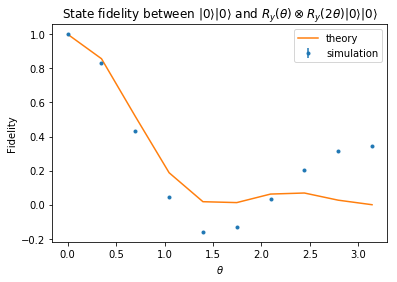

In [23]:
pyplot.errorbar(np.linspace(0, np.pi, points), res, res_std_err, fmt=".", label="simulation")
pyplot.plot(np.linspace(0, np.pi, points), 
            (1/2+1/2*np.cos(np.linspace(0, np.pi, points)))*(1/2+1/2*np.cos(2*np.linspace(0, np.pi, points))),
            label="theory")
pyplot.xlabel(r"$\theta$")
pyplot.ylabel("Fidelity")
pyplot.legend()
pyplot.title(r"State fidelity between $\left|0\right\rangle\left|0\right\rangle$ and $R_y(\theta)\otimes R_y(2\theta)\left|0\right\rangle\left|0\right\rangle$")

## Process fidelity between $I$ and $R_y(\theta)$

In [26]:

p = Program(I(0))
qubits = [0]
ii_proc = generate_exhaustive_process_dfe_experiment(p, qubits, bm)
ii_proc_mc = generate_monte_carlo_process_dfe_experiment(p, qubits, bm, n_terms=32)

### Exhaustive

In [27]:
points = 10
res = []
res_std_err = []
for theta in np.linspace(0, np.pi, points): 
    ii_proc.program = Program(RY(theta,0))
    ii_proc_data = acquire_dfe_data(qvm,ii_proc,num_shots=500)
    fid_est, fid_std_err = estimate_dfe(ii_proc_data, 'process')
    res.append(fid_est)
    res_std_err.append(fid_std_err)

Text(0.5, 1.0, 'Process fidelity between $I$ and $R_y(\\theta)$')

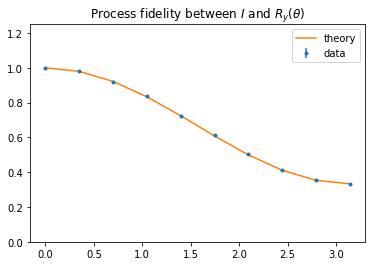

In [28]:
pyplot.errorbar(np.linspace(0, np.pi, points), res, res_std_err, fmt=".", label="data")
pyplot.plot(np.linspace(0, np.pi, points), 
            (4*np.cos(np.linspace(0, np.pi, points)/2)**2+2)/6,
            label="theory")
#pyplot.axhline(0.2380952380952381+0.1, color="red", ls="--")
pyplot.legend()
pyplot.ylim(0,1.25)
pyplot.title(r"Process fidelity between $I$ and $R_y(\theta)$")

### Monte Carlo

In [29]:
points = 10
res = []
res_std_err = []
for theta in np.linspace(0, np.pi, points): 
    ii_proc_mc.program = Program(RY(theta,0))
    ii_proc_mc_data = acquire_dfe_data(qvm, ii_proc_mc, num_shots=500)
    fid_est, fid_std_err = estimate_dfe(ii_proc_mc_data, 'process')
    res.append(fid_est)
    res_std_err.append(fid_std_err)

In [ ]:
pyplot.errorbar(np.linspace(0, np.pi, points), res, res_std_err, fmt=".", label="data")
pyplot.plot(np.linspace(0, np.pi, points), 
            (4*np.cos(np.linspace(0, np.pi, points)/2)**2+2)/6,
            label="theory")
pyplot.legend()
pyplot.ylim(0,1.25)
pyplot.title(r"Process fidelity between $I$ and $R_y(\theta)$")

## Advanced 

In [36]:
# 1. include qubits that have nothing done to them (leave then in zero to measure x talk)
# 2. prepare those qubits in |+>

In [ ]:
# Parallel state and process DFE